In [2]:
if(!require(ggplot2)){install.packages("ggplot2"); library(ggplot2)}
if(!require(cowplot)){install.packages("cowplot"); library(cowplot)}

if(!require(readr)){install.packages("readr"); library(readr)}

if(!require(plyr)){install.packages("plyr"); library(plyr)}
if(!require(dplyr)){install.packages("dplyr"); library(dplyr)}
if(!require(tidyr)){install.packages("tidyr"); library(tidyr)}
if(!require(magrittr)){install.packages("magrittr"); library(magrittr)}
if(!require(MCMCglmm)){install.packages("MCMCglmm"); library(MCMCglmm)}

if(!require(lme4)){install.packages("lme4"); library(lme4)}
if(!require(lmerTest)){install.packages("lmerTest"); library(lmerTest)}
if(!require(lme4qtl)){
    if(!require(remotes)) install.packages("remotes")
    remotes::install_github('variani/lme4qtl'); library(lme4qtl)}
if(!require(sjstats)){install.packages("sjstats"); library(sjstats)}
if(!require(wesanderson)){install.packages("wesanderson"); library(wesanderson)}
if(!require(corrplot)){install.packages("corrplot"); library(corrplot)}


if(!require(snpStats)){if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager"); BiocManager::install("snpStats"); library(snpStats)}

In [3]:
traits <- c('movement_count','mean_movement_length',
            'speed_in_movement_mean','dist_travelled')

f1s_df_ts <- read.csv("f1s_df_ts.csv")
parents_df_ts <- read.csv("parents_df_ts.csv")

f1s_df_36 <- read.csv("f1s_df_36.csv")
parents_df_36 <- read.csv("parents_df_36.csv")

grm <- as.matrix(read.table("female_parents.biSNP.sing.HW.gatk.GQfilter.MAF05.w100s1r08.rel"))
colnames(grm) <- rownames(grm) <- read.table("female_parents.biSNP.sing.HW.gatk.GQfilter.MAF05.w100s1r08.rel.id")[,2]

f1_grm <- grm[grep("F1",colnames(grm)),grep("F1",colnames(grm))]
p_grm <- grm[-grep("F1",colnames(grm)),-grep("F1",colnames(grm))]

f1s <- grep("_S",row.names(grm))
parental_grm <- as.matrix(grm)

family <- sapply(row.names(parental_grm),FUN=function(x){strsplit(x,"_")[[1]][4]})
row.names(parental_grm) <- colnames(parental_grm) <- family

In [4]:
grm <- as.matrix(read.table("female_parents.biSNP.sing.HW.gatk.GQfilter.MAF05.w100s1r08.rel"))
colnames(grm) <- rownames(grm) <- read.table("female_parents.biSNP.sing.HW.gatk.GQfilter.MAF05.w100s1r08.rel.id")[,2]

f1_grm <- grm[grep("F1",colnames(grm)),grep("F1",colnames(grm))]
p_grm <- grm[-grep("F1",colnames(grm)),-grep("F1",colnames(grm))]

f1s <- grep("_S",row.names(grm))
parental_grm <- as.matrix(grm)

family <- sapply(row.names(parental_grm),FUN=function(x){strsplit(x,"_")[[1]][4]})
row.names(parental_grm) <- colnames(parental_grm) <- family

In [5]:
f1s_df_ts <- f1s_df_ts[f1s_df_ts$Family %in% colnames(parental_grm),]


#Filtering as needed
combined_filtered_df <- f1s_df_ts
combined_filtered_df = combined_filtered_df[which(combined_filtered_df$Empty == F),]
combined_filtered_df = combined_filtered_df[which(!is.na(combined_filtered_df$Treatment)),]
combined_filtered_df = combined_filtered_df[which(!is.na(combined_filtered_df$Batch)),]
# Account for framerate
combined_filtered_df$dist_travelled <- combined_filtered_df$dist_travelled/10

#Ensure the flies still move some -- no dead flies!
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$movement_count > 10),]
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$movement_count < 10000),]
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$mean_of_mean_in_movement_speed < 100),]
# combined_filtered_df = combined_filtered_df[combined_filtered_df$vel_par_in_movement_mean > 5 & combined_filtered_df$vel_par_in_movement_mean < 100,]
# combined_filtered_df <- combined_filtered_df[which(combined_filtered_df$speed_in_movement_var < 500),]
# combined_filtered_df <- combined_filtered_df[which(combined_filtered_df$mean_mov < 20000),]


f1s_df_ts <- combined_filtered_df

#Append meaningful individual ID
f1s_df_ts$indiv_id <- paste0(f1s_df_ts$Batch,"_",f1s_df_ts$Family,"_",f1s_df_ts$Well_orderAsTracked)

In [6]:
f1s_df_36 <- f1s_df_36[f1s_df_36$Family %in% colnames(parental_grm),]


#Filtering as needed
combined_filtered_df <- f1s_df_36
combined_filtered_df = combined_filtered_df[which(combined_filtered_df$Empty == F),]
combined_filtered_df = combined_filtered_df[which(!is.na(combined_filtered_df$Treatment)),]
combined_filtered_df = combined_filtered_df[which(!is.na(combined_filtered_df$Batch)),]
# Account for framerate
combined_filtered_df$dist_travelled <- combined_filtered_df$dist_travelled/10

#Ensure the flies still move some -- no dead flies!
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$movement_count > 10),]
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$movement_count < 10000),]
# combined_filtered_df = combined_filtered_df[which(combined_filtered_df$mean_of_mean_in_movement_speed < 100),]
# combined_filtered_df = combined_filtered_df[combined_filtered_df$vel_par_in_movement_mean > 5 & combined_filtered_df$vel_par_in_movement_mean < 100,]
# combined_filtered_df <- combined_filtered_df[which(combined_filtered_df$speed_in_movement_var < 500),]
# combined_filtered_df <- combined_filtered_df[which(combined_filtered_df$mean_mov < 20000),]


f1s_df_36 <- combined_filtered_df

#Append meaningful individual ID
f1s_df_36$indiv_id <- paste0(f1s_df_36$Batch,"_",f1s_df_36$Family,"_",f1s_df_36$Well_orderAsTracked)

# Some GRM shenanigans

In [7]:
path <- paste("female_parents.biSNP.sing.HW.gatk.GQfilter.MAF05.w100s1r08", c(".bed", ".bim", ".fam"), sep = "")
SNPs <- read.plink(path[1], path[2], path[3])

genotype_mat <- as(SNPs$genotypes,"numeric")
row.names(genotype_mat) <- sapply(row.names(genotype_mat),FUN=function(x){strsplit(x,"_")[[1]][4]})

strs <- sapply(unique(f1s_df_ts$Family),toString)

# Expand genotype matrix to fit phenotype vector length
gt_mat <- genotype_mat[strs,]


mean_filled_gt_mat = gt_mat

fillNAX= TRUE
if(sum(is.na(mean_filled_gt_mat))>0){
    if(fillNAX){
      mean_filled_gt_mat = apply(mean_filled_gt_mat,2,function(x) {
        if(sum(is.na(x)) > 0){
          x[is.na(x)] = mean(x,na.rm=T)
        }
        x
      })
    } else{
      mean_filled_gt_mat[,colSums(is.na(X))>1] = 0
    }
  }

name_split <- sapply(colnames(gt_mat),FUN=function(x){strsplit(x,split=c("\\["))[[1]][1]})
chr <- sapply(name_split,FUN=function(x){strsplit(x,split=":")[[1]][1]})
pos <- as.numeric(sapply(name_split,FUN=function(x){strsplit(x,split=":")[[1]][2]}))

map_g = data.frame(snp = name_split,chr = chr, pos=pos,ref=rep("A",ncol(gt_mat)),alt=rep("T",ncol(gt_mat)))
# chr <- mapvalues(map_g$chr,unique(map_g$chr),c(1,2,3,4,5,6))


# Filtering out weird families

In [23]:
scaledFamilyMeans = function(f1s_df_ts){
    scaled_f1s <- f1s_df_ts
    for (treatment in c("C","R","HS")){
        for (time in unique(f1s_df_ts$slicetime)){
            for (trait in traits){
                scaled_f1s[scaled_f1s$Treatment == treatment & scaled_f1s$slicetime == time, traits] <- scale(scaled_f1s[scaled_f1s$Treatment == treatment & scaled_f1s$slicetime == time,traits])
            }
        }
    }
    family_means_df = scaled_f1s %>% 
        select(Treatment, slicetime, Family, all_of(traits)) %>%
        pivot_longer(all_of(traits)) %>%
        group_by(Treatment, slicetime, Family, name) %>%
        summarise(value = mean(value))
    family_means_df
}
make_familyPlots = function(f1s_df_ts){
    family_means_df = scaledFamilyMeans(f1s_df_ts)
    family_means = family_means_df %>%
        ggplot(aes(slicetime, value, group = interaction(Treatment, slicetime), color = Treatment)) + 
        geom_jitter(width = 0.3) + facet_grid(Treatment~name) +theme_cowplot() + background_grid()
    family_means
}

`summarise()` has grouped output by 'Treatment', 'slicetime', 'Family'. You can override using the `.groups` argument.



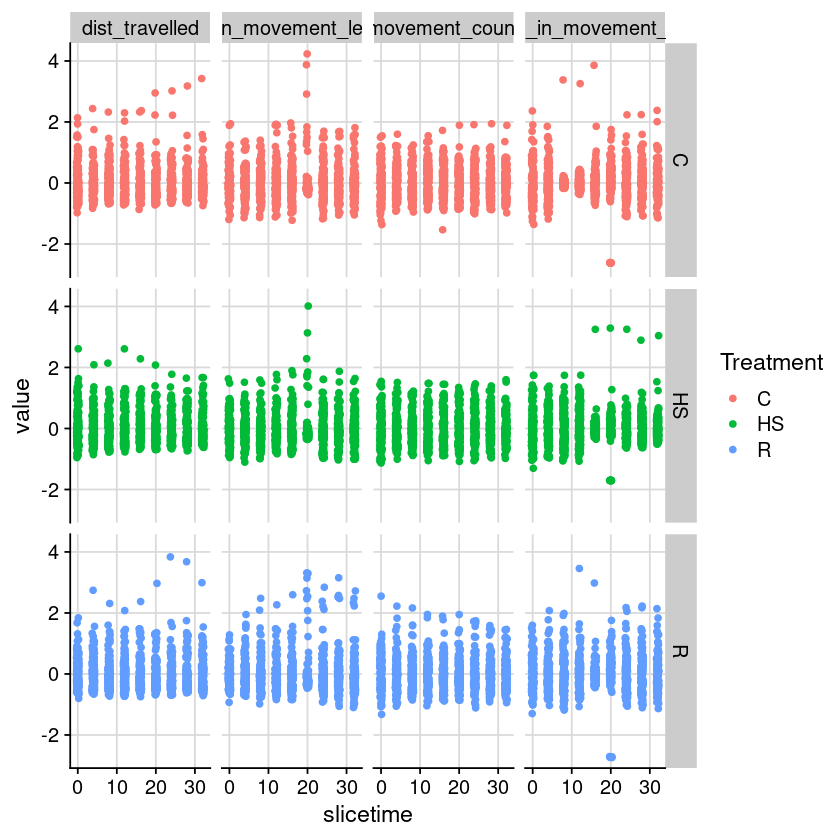

In [24]:
family_means = make_familyPlots(f1s_df_ts)
family_means
#save_plot(filename = "family_mean_plots.png", family_means, base_height = 4, base_asp = 1.3, ncol = 4, nrow = 3)

In [32]:
family_means_df = scaledFamilyMeans(f1s_df_ts)
var_leverage_df = data.frame(Treatment = NA_character_, slicetime = NA_integer_, 
                           name = NA_character_, 
                           Family = NA_integer_, 
                           var_ratio = NA_real_)
for(t in unique(family_means_df$Treatment)){
    for(s in unique(family_means_df$slicetime)){
        for(n in unique(family_means_df$name)){
            current_slice = filter(family_means_df, Treatment == t,
                                                    slicetime == s,
                                                    name == n)
            total_var = var(current_slice$value)
            for(fam in unique(current_slice$Family)){
                var_leverage_df = rbind(var_leverage_df, data.frame(Treatment = t, 
                           slicetime = s, 
                           name = n, 
                           Family = fam, 
                           var_ratio = var(filter(current_slice, Family != fam)$value)/total_var))
            }
        }
    }
}
var_leverage_df = na.omit(var_leverage_df)

`summarise()` has grouped output by 'Treatment', 'slicetime', 'Family'. You can override using the `.groups` argument.



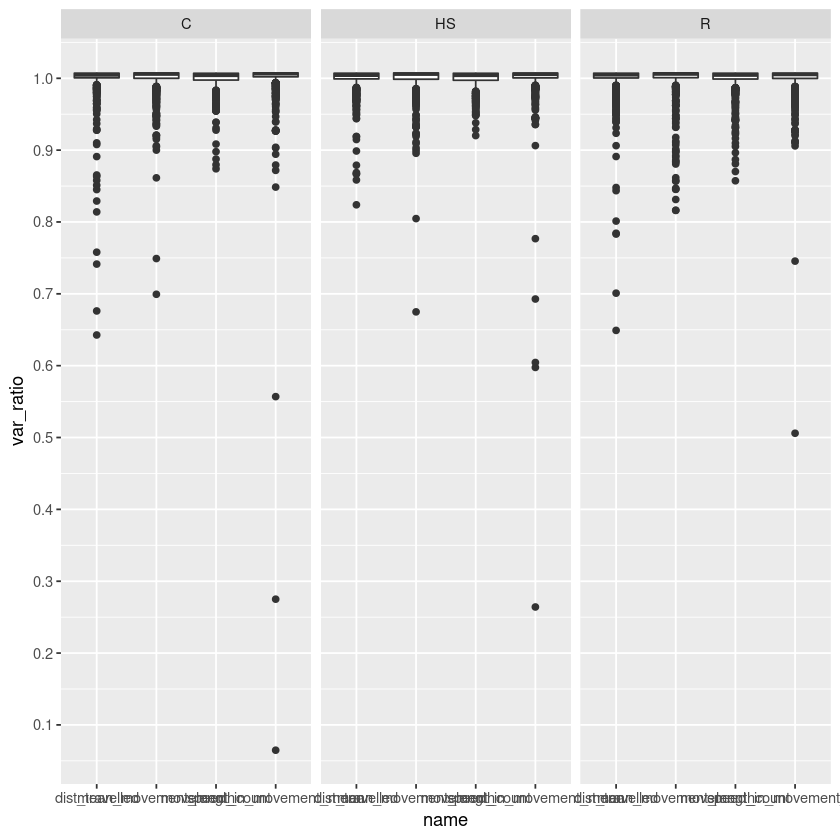

In [50]:
var_leverage_df %>% 
    ggplot(aes(name, var_ratio)) + geom_boxplot() + scale_y_continuous(n.breaks = 10) + facet_wrap(~Treatment)

In [51]:
var_lev = var_leverage_df %>%
    filter(var_ratio < 0.85) %>%
    select(Family) 

family_means_df = scaledFamilyMeans(f1s_df_ts)
too_small_values = family_means_df %>%
    filter(name == "speed_in_movement_mean",

           slicetime == 20, 
          value < -1) %>%
    arrange(value) 
#write_csv(too_small_values, file = "too_small_speed_in_movement_mean_atTime20.csv")
weird_families = unique(c(too_small_values$Family, var_lev$Family))
weird_families

`summarise()` has grouped output by 'Treatment', 'slicetime', 'Family'. You can override using the `.groups` argument.



[1] 302 329 335 304 317 340 337 313 283 212 366 383  81 374 365 377 363

In [52]:
f1s_df_ts_filtered = filter(f1s_df_ts, !Family %in% weird_families)

`summarise()` has grouped output by 'Treatment', 'slicetime', 'Family'. You can override using the `.groups` argument.



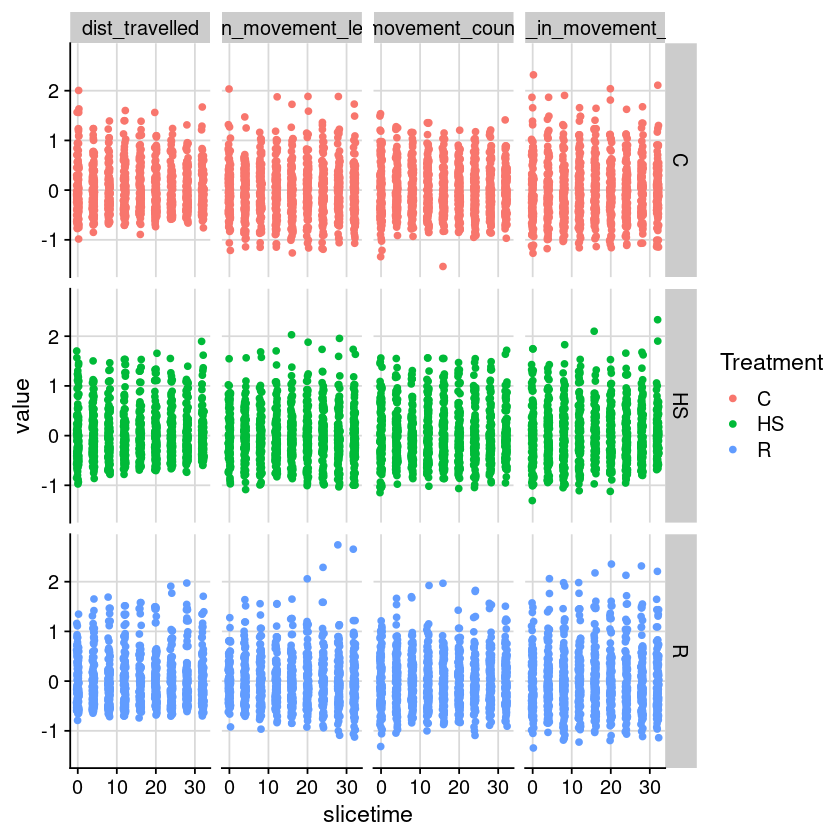

In [53]:
make_familyPlots(f1s_df_ts_filtered)

# Heritability estimates

In [54]:
h2_estimates_mcmc <- data.frame(trait=character(),
                           treatment=character(),
                           h2=numeric(),
                           slicetime=numeric(),
                           lower = numeric(),
                           upper = numeric(),
                           p=numeric())
traits <- c('movement_count','mean_movement_length','speed_in_movement_mean','dist_travelled')

#family_A_inv = Matrix::solve(parental_grm)
#family_A_inv = evolqg::ExtendMatrix(family_A_inv, ret.dim = ncol(family_A_inv)-1)$ExtMat
#family_A_inv =- as(family_A_inv, "sparseMatrix")
prior = list(G = list(G1 = list(V = 1, nu = 0.002)),
             R = list(V = 1, nu = 0.002))


for (treatment in c("C","R","HS")){
    print(treatment)
    for (time in unique(f1s_df_ts_filtered$slicetime)){
        print(time)
        for (trait in traits){
            print(trait)
            slice <- f1s_df_ts_filtered[f1s_df_ts_filtered$Treatment == treatment & 
                                        f1s_df_ts_filtered$slicetime == time,] #mapping_df[mapping_df$Treatment == treatment & mapping_df$slicetime == time,]
            slice[,traits] = scale(slice[,traits])
            form = as.formula(paste0(trait, "~","1"))
            full_mod <- MCMCglmm(form,
                                 data = slice,
                                 random = ~Family,
                                 prior = prior,
                                 #ginverse = list(Family = family_A_inv),
                                 family = "gaussian", nitt = 23000, burnin = 3000)
            mod_sum = summary(full_mod)
            mean = mod_sum$Gcovariances[1]
            se <- mod_sum$Gcovariances[2:3]
            p <- sum(full_mod$VCV[,"Family"] < 0) / length( full_mod$VCV[,"Family"])

            h2_estimates_mcmc[nrow(h2_estimates_mcmc) + 1,] <- data.frame(trait ,treatment, mean, time, se[1], se[2], p)
        }
    }
}

[1] "C"
[1] 0
[1] "movement_count"

                       MCMC iteration = 0

                       MCMC iteration = 1000

                       MCMC iteration = 2000

                       MCMC iteration = 3000

                       MCMC iteration = 4000

                       MCMC iteration = 5000

                       MCMC iteration = 6000

                       MCMC iteration = 7000

                       MCMC iteration = 8000

                       MCMC iteration = 9000

                       MCMC iteration = 10000

                       MCMC iteration = 11000

                       MCMC iteration = 12000

                       MCMC iteration = 13000

                       MCMC iteration = 14000

                       MCMC iteration = 15000

                       MCMC iteration = 16000

                       MCMC iteration = 17000

                       MCMC iteration = 18000

                       MCMC iteration = 19000

                       MCMC iteration

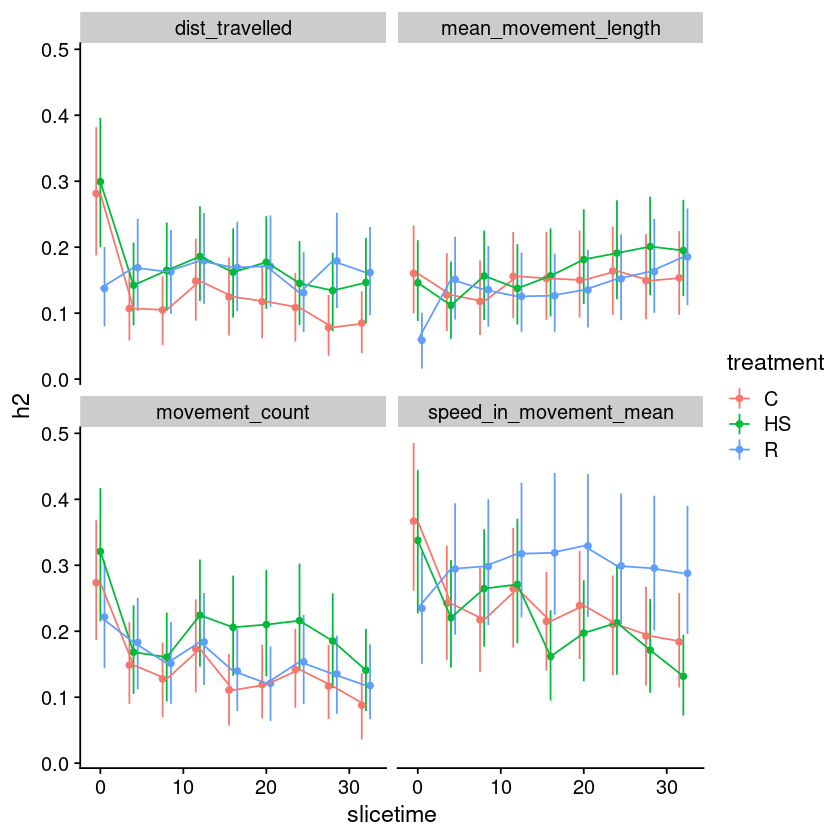

In [63]:
h2_estimates_mcmc %>%
    #filter(slicetime %in% c(0, 32)) %>%
ggplot(aes(slicetime, h2, color = treatment)) + 
    geom_point(position=position_dodge(width = 1.5)) + 
geom_linerange(aes(ymin = lower, ymax = upper), position=position_dodge(width = 1.5)) + 
geom_line() + facet_wrap(~trait) + theme_cowplot()

In [49]:
x = scaled_f1s %>% 
    select(Treatment, slicetime, Family, all_of(traits)) %>%
    pivot_longer(all_of(traits)) %>%
    group_by(Treatment, slicetime, Family, name) %>%
    summarise(value = mean(value))
unique(x$slicetime)

`summarise()` has grouped output by 'Treatment', 'slicetime', 'Family'. You can override using the `.groups` argument.



[1]  0  4  8 12 16 20 24 28 32

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


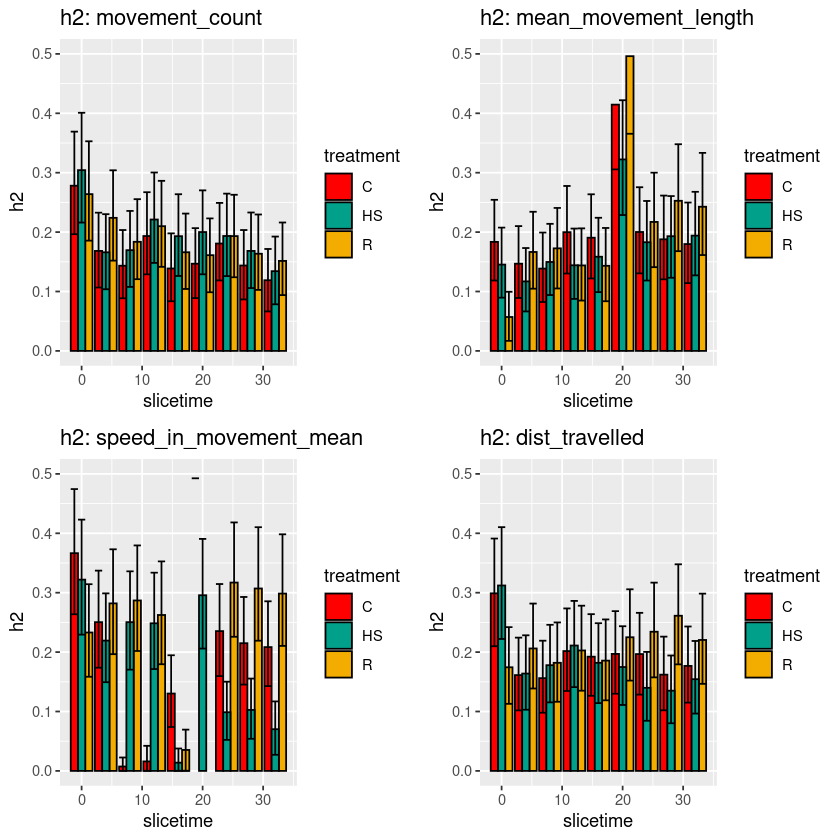

In [10]:
h2_plot_list_mcmc = list()
for (i in seq_along(traits)){
  trait = traits[i]
  h2_estimates_mcmc$h2 <- as.numeric(h2_estimates_mcmc$h2)
  h2_estimates_mcmc$slicetime <- as.numeric(h2_estimates_mcmc$slicetime)
  h2_trait <- h2_estimates_mcmc[h2_estimates_mcmc$trait == trait,]
  plt <- ggplot(h2_trait, aes(y=h2, fill=treatment, x=slicetime))  + ylim(0,0.5) +
    geom_bar(position="dodge", stat="identity", colour="black") +
    geom_errorbar(aes(ymin = lower, ymax = upper), position="dodge", stat="identity", colour="black") +
    scale_fill_manual(values = wes_palette("Darjeeling1",3))+
    ggtitle(paste0("h2: ", trait))
  h2_plot_list_mcmc[[i]] = plt
}

plot_grid(plotlist = h2_plot_list_mcmc)

In [9]:
unique(f1s_df_ts$slicetime)

[1]  0  4  8 12 16 20 24 28 32

# G-Matrix estimates

In [12]:
multi_trait_formula = paste0("cbind(", paste(traits, collapse = ", "), ") ~ trait")
prior = list(G = list(G1 = list(V = diag(length(traits)), nu = 1.002)),
             R =           list(V = diag(length(traits)), nu = 1.002))

n_models = 6  # number of models (times X treatments)
multi_trait_model = vector("list", n_models)
Gs_list = vector("list", n_models) # Posterior sample of G-matrix
G_list = vector("list", n_models)  # G-matrix estimate
corrG_list = vector("list", n_models) # Genetic correlation matrix 

k = 1
for (treatment in c("C","R","HS")){
    print(treatment)
    for (time in c(0,32)){
        slice <- f1s_df_ts[f1s_df_ts$Treatment == treatment & f1s_df_ts$slicetime == time,]
        # scalling the data makes the diagonal of the estimated G be the heritability
        slice[,traits] = scale(slice[,traits])
        model <- MCMCglmm(as.formula(multi_trait_formula),
                                      data = slice,
                                      random = ~us(trait):Family,
                                      rcov = ~us(trait):units,
                                      prior = prior,
                                      #ginverse = list(Family = family_A_inv),
                                      family = rep("gaussian", length(traits)), 
                                      nitt = 130000, burnin = 30000,
                                      thin = 10,
                                      verbose=FALSE)
        multi_trait_model[[k]] = model
        Gs_list[[k]] = array(model$VCV[,grep("Family", colnames(model$VCV))], dim = c(nrow(model$VCV), 4, 4))
        G_list[[k]] = apply(Gs_list[[k]], c(2, 3), mean)
        corrG_list[[k]] = cov2cor(G_list[[k]])
        names(multi_trait_model)[k] = names(Gs_list)[k] = names(G_list)[k] = names(corrG_list)[k] = paste(treatment, time, sep = ".")
        k = k + 1
    }
}


[1] "C"
[1] "R"
[1] "HS"


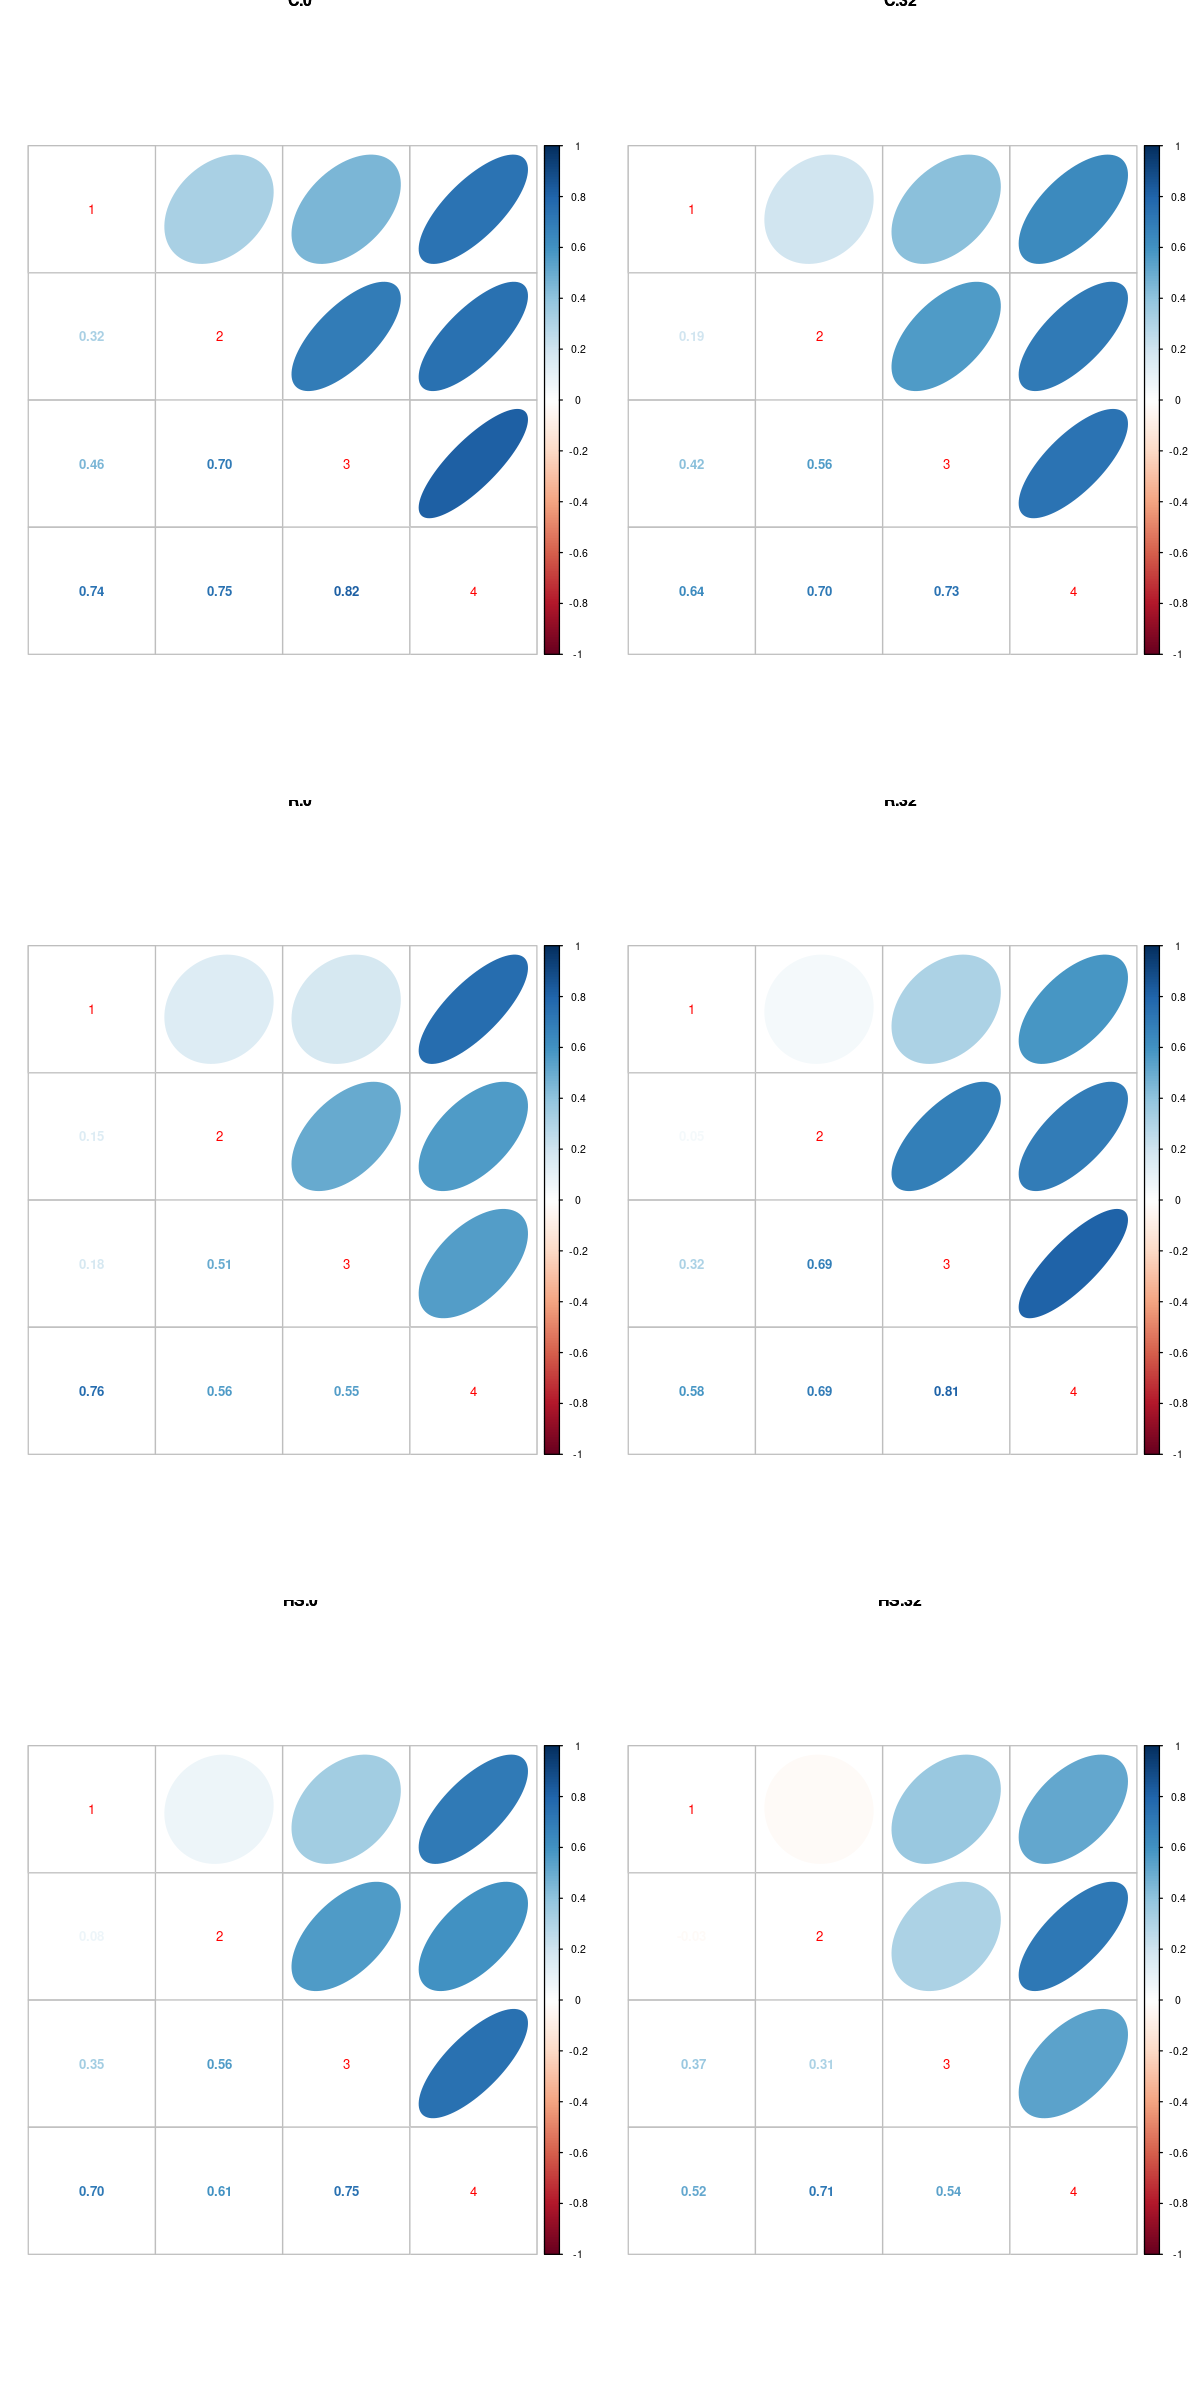

In [13]:
options(repr.plot.width=10, repr.plot.height=20)
# Pretty big genetic correlations
par(mfrow = c(3, 2))
for(i in 1:length(corrG_list)){
    corrplot.mixed(corrG_list[[i]] ,upper = "ellipse", main = names(corrG_list)[i])
    }

In [14]:
library(evolqg)
## Some non-consistent changes in mean genetic correlation over time
matrix(sapply(corrG_list, CalcEigenVar), 3, 2, byrow = T, dimnames = list(c("C", "R", "HS"), c(0, 32))) |> round(2)

ERROR: Error in parse(text = x, srcfile = src): <text>:3:106: unexpected '>'
2: ## Some non-consistent changes in mean genetic correlation over time
3: matrix(sapply(corrG_list, CalcEigenVar), 3, 2, byrow = T, dimnames = list(c("C", "R", "HS"), c(0, 32))) |>
                                                                                                            ^
